In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from itertools import combinations
from pyECLAT import ECLAT
from time import time
from matplotlib import pyplot as plt

In [2]:
# Считываем данные из csv
data = pd.read_csv('retail_dataset.csv', dtype='str')
data.columns = range(data.shape[1])
data

,0,1,2,3,4,5,6
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
310,Bread,Eggs,Cheese,NaN,NaN,NaN,NaN
311,Meat,Milk,Pencil,NaN,NaN,NaN,NaN
312,Bread,Cheese,Eggs,Meat,Pencil,Diaper,Wine
313,Meat,Cheese,NaN,NaN,NaN,NaN,NaN


In [3]:
# извлекаем все названия продуктов
names = set(pd.Series(data.values.flatten()).dropna().unique().tolist())
names

{'Bagel',
 'Bread',
 'Cheese',
 'Diaper',
 'Eggs',
 'Meat',
 'Milk',
 'Pencil',
 'Wine'}

In [4]:
# Преобразуем в таблицу с бинарными данными
transactions = pd.DataFrame([{name: name in x.dropna().unique() for name in names} for x in data.iloc])
transactions

,Pencil,Wine,Milk,Eggs,Cheese,Bread,Diaper,Meat,Bagel
0,True,True,False,True,True,True,True,True,False
1,True,True,True,False,True,True,True,True,False
2,False,True,True,True,True,False,False,True,False
3,False,True,True,True,True,False,False,True,False
4,True,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
310,False,False,False,True,True,True,False,False,False
311,True,False,True,False,False,False,False,True,False
312,True,True,False,True,True,True,True,True,False
313,False,False,False,False,True,False,False,True,False


In [5]:
# Запустить алгоритм apriori и найти ассоциативные правила
# data - исходная таблица с данными (для ECLAT)
# transactions - бинарные данные (для apriori, fpgrowth)
# min_support - пороговое значение поддержки
# confidence_threshold - пороговое значение достоверности
# Выход: таблица со значениями поддержки, таблица с ассоциативными правилами и время работы
def fit(data, transactions, min_support, confidence_threshold):
    t0 = time()
    apriori_results = apriori(transactions, min_support=min_support, use_colnames=True)
    
    apriori_rules = pd.DataFrame(association_rules(apriori_results, metric="confidence", min_threshold=confidence_threshold))
    t1 = time()

    return apriori_results, apriori_rules, t1 - t0

In [6]:
# Выведем результаты для порогового значения достоверности в 80%
apriori_results, apriori_rules, _ = fit(data, transactions, 0.1, 0.8)

In [7]:
apriori_results

,support,itemsets
0,0.361905,(Pencil)
1,0.438095,(Wine)
2,0.501587,(Milk)
3,0.438095,(Eggs)
4,0.501587,(Cheese)
...,...,...
95,0.104762,"(Diaper, Meat, Bagel)"
96,0.104762,"(Wine, Milk, Cheese, Eggs)"
97,0.101587,"(Wine, Milk, Cheese, Meat)"
98,0.111111,"(Wine, Cheese, Meat, Eggs)"


In [8]:
apriori_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(Milk, Eggs)",(Cheese),0.244444,0.501587,0.196825,0.805195,1.605293,1.0,0.074215,2.558519,0.499051,0.358382,0.609149,0.598800
1,"(Milk, Meat)",(Cheese),0.244444,0.501587,0.203175,0.831169,1.657077,1.0,0.080564,2.952137,0.524816,0.374269,0.661262,0.618116
2,"(Eggs, Meat)",(Cheese),0.266667,0.501587,0.215873,0.809524,1.613924,1.0,0.082116,2.616667,0.518717,0.390805,0.617834,0.619952
3,"(Wine, Milk, Meat)",(Cheese),0.126984,0.501587,0.101587,0.800000,1.594937,1.0,0.037894,2.492063,0.427273,0.192771,0.598726,0.501266
4,"(Eggs, Milk, Meat)",(Cheese),0.177778,0.501587,0.152381,0.857143,1.708861,1.0,0.063210,3.488889,0.504505,0.289157,0.713376,0.580470


In [9]:
# Сравним показатели при разных пороговых значениях

thresholds = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]

time_arr = np.zeros(len(thresholds))
count_arr = np.zeros(len(thresholds), dtype=np.int64)
maxlen_arr = np.zeros(len(thresholds), dtype=np.int64)
count_rules = np.zeros(len(thresholds), dtype=np.int64)

for i, conf_thr in enumerate(thresholds):
    apriori_results, apriori_rules, t = fit(data, transactions, 0.1, conf_thr)
    count = len(apriori_rules)
    maxlen = max([0] + [len(x) for x in apriori_rules.antecedents])
    
    time_arr[i] = t
    count_arr[i] = count
    maxlen_arr[i] = maxlen
    count_rules[i] = np.sum(np.array([len(x.antecedents) + len(x.consequents) for x in apriori_rules.iloc]) <= 7)

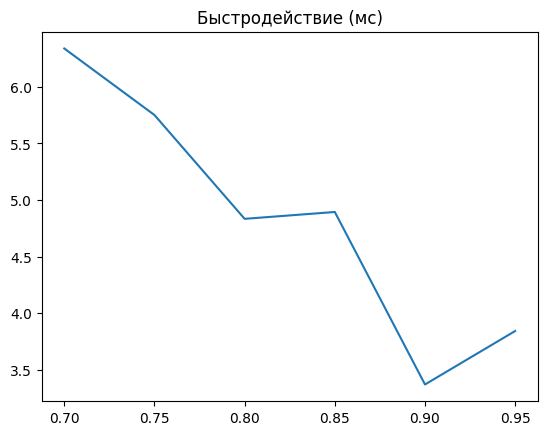

In [10]:
# Построим соответствующие диаграммы
plt.plot(thresholds, time_arr * 1000)
plt.title("Быстродействие (мс)")
plt.show()

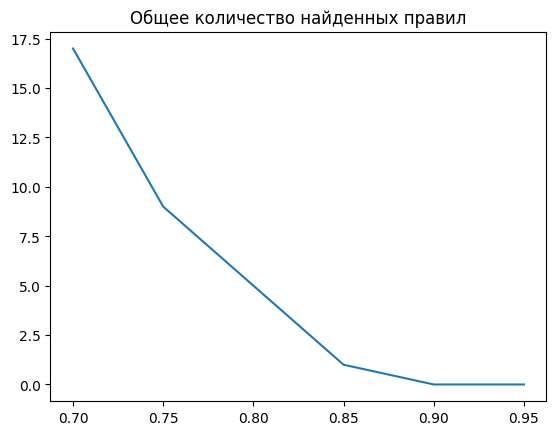

In [11]:
plt.plot(thresholds, count_arr)
plt.title("Общее количество найденных правил")
plt.show()

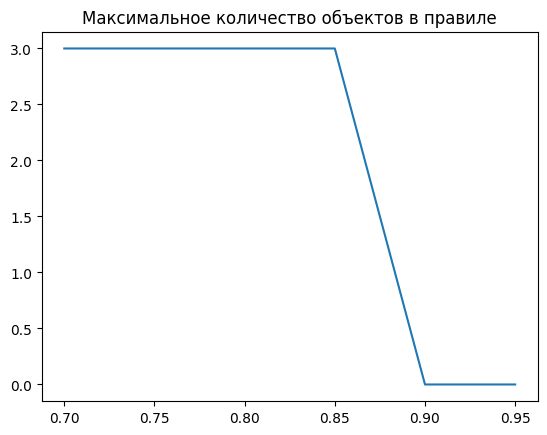

In [12]:
plt.plot(thresholds, maxlen_arr)
plt.title("Максимальное количество объектов в правиле")
plt.show()

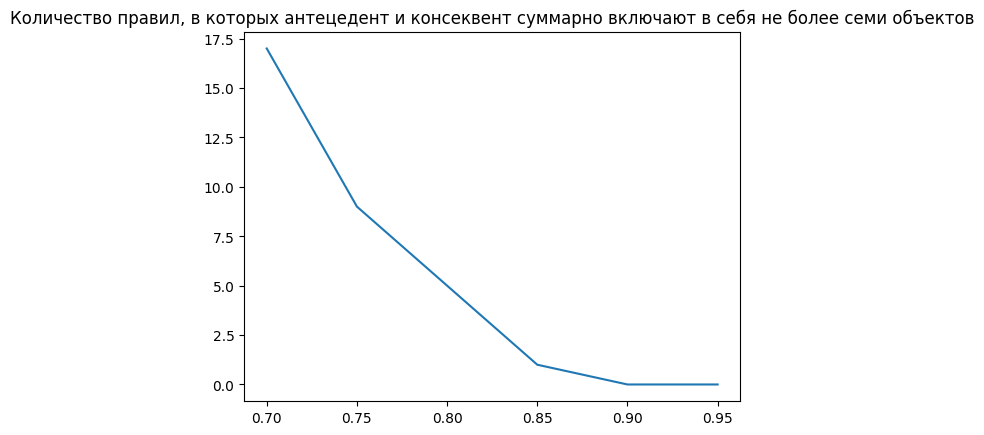

In [13]:
plt.plot(thresholds, count_rules)
plt.title("Количество правил, в которых антецедент и консеквент суммарно включают в себя не более семи объектов")
plt.show()